# BoTorch Tutorial 1

## Testing acquisition functions in low-dimensional, continuous domains

A simple BoTorch tutorial.

I'll be comparing several standard acquisition functions on relatively low-dimensional functions.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch

from molbo.utils.functions import Toy1DFunction
from molbo.viz import plot_1d

sns.set_style("whitegrid")
sns.set_palette("muted")

device = "cuda" if torch.cuda.is_available() else "cpu"
DTYPE = torch.float64
t_params = {
    'device': device,
    'dtype': DTYPE,
}

print(f"Device: {device}\nData type: {DTYPE}")

Device: cpu
Data type: torch.float64


/home/wvir/miniconda3/envs/molbo/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from botorch.acquisition import (
    LogExpectedImprovement,
)
from botorch.fit import fit_gpytorch_mll
from botorch.models import SingleTaskGP
from botorch.models.transforms.input import Normalize
from botorch.optim import optimize_acqf
from botorch.test_functions import Branin, Hartmann
from gpytorch.mlls import ExactMarginalLogLikelihood

In [3]:
def init_gp(train_X, train_y, state_dict=None):
    model = SingleTaskGP(
        train_X,
        train_y,
        input_transform=Normalize(d=train_X.shape[-1])
    )

    mll = ExactMarginalLogLikelihood(
        model.likelihood,
        model
    )

    if state_dict is not None:
        model.load_state_dict(state_dict)

    fit_gpytorch_mll(mll)

    return model

def get_f_star(f, bounds):
    from scipy.optimize import differential_evolution

    def objective(x):
        x_torch = torch.tensor(x, dtype=torch.float64).unsqueeze(0)
        return -f(x_torch).item()

    result = differential_evolution(
        objective,
        bounds=bounds.T,
        seed=42,
        maxiter=1000,
        atol=1e-8,
        tol=1e-8
    )

    return -result.fun

def evaluate_regret(train_y, f_star):
    simple_regret, cumulative_regret = [], []
    for i in range(1, len(train_y)+1):
        max_obs = train_y[:i].max()
        simple_regret.append(f_star - max_obs)
        cumulative_regret.append((f_star - train_y[:i]).sum())

    return torch.tensor(simple_regret), torch.tensor(cumulative_regret)

## Optimizing a 1D function

In [4]:
# Define the domain, visualize function:
# f = Ackley(dim=1, negate=True)
f = Toy1DFunction()

bounds = f.bounds

# Generate 3 random samples
n_init = 3
train_X = bounds[1] * torch.rand(n_init, 1, **t_params)
train_y = f(train_X).unsqueeze(-1)

X_plot = torch.linspace(bounds[0].item(), bounds[1].item(), int((bounds[1] - bounds[0]) * 20), **t_params).unsqueeze(-1)

In [82]:
n_iters = 10
beta = 2.0
plot = False

In [ ]:
for iteration in range(n_iters):

    # Fit GP
    gp_model = init_gp(train_X, train_y)

    # Create acquisition function
    acq_func = LogExpectedImprovement(model=gp_model, best_f=train_y.max().item())

    # Optimize acquisition function
    new_X, acq_value = optimize_acqf(
        acq_function=acq_func,
        bounds=bounds,
        q=1,
        num_restarts=10,
        raw_samples=512,
    )

    # Make observation
    new_y = f(new_X).unsqueeze(-1)

    # Visualize
    if plot:
        plot_1d(gp_model, X_plot, train_X, new_X, f, acq_func)

    # Update training data
    train_X = torch.cat([train_X, new_X])
    train_y = torch.cat([train_y, new_y])

In [7]:
f_star = get_f_star(f, bounds)

simple_regret, cumulative_regret = evaluate_regret(train_y[n_init:], f_star)

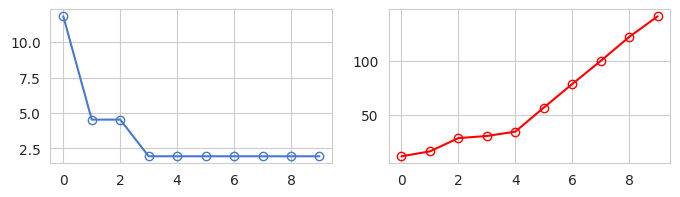

In [8]:
xs = torch.arange(n_iters)

plt.figure(figsize=(8, 2))

plt.subplot(121)
plt.plot(xs, simple_regret, marker='o', markerfacecolor='none')

plt.subplot(122)
plt.plot(xs, cumulative_regret, color='red', marker='o', markerfacecolor='none');

## Optimizing a 2D function

In [9]:
f = Branin(negate=True)

bounds = f.bounds

n_init = 4
train_X = bounds[:, 0] + (torch.rand((2, n_init)) * bounds.diff()).T
train_y = f(train_X).unsqueeze(-1)

In [10]:
n_iters = 10

for iteration in range(n_iters):

    # Fit GP
    gp_model = init_gp(train_X, train_y)

    # Create acquisition function
    acq_func = LogExpectedImprovement(model=gp_model, best_f=train_y.max().item())

    # Optimize acquisition function
    new_X, acq_value = optimize_acqf(
        acq_function=acq_func,
        bounds=bounds,
        q=1,
        num_restarts=10,
        raw_samples=512,
    )

    # Make observation
    new_y = f(new_X).unsqueeze(-1)

    # Update training data
    train_X = torch.cat([train_X, new_X])
    train_y = torch.cat([train_y, new_y])

f_star = get_f_star(f, bounds)

simple_regret, cumulative_regret = evaluate_regret(train_y[n_init:], f_star)

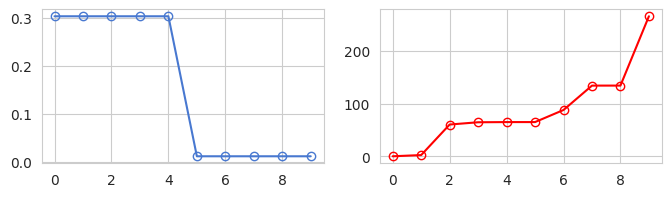

In [11]:
xs = torch.arange(n_iters)

plt.figure(figsize=(8, 2))

plt.subplot(121)
plt.plot(xs, simple_regret, marker='o', markerfacecolor='none')

plt.subplot(122)
plt.plot(xs, cumulative_regret, color='red', marker='o', markerfacecolor='none');

## Optimizing a 6D function

In [12]:
f = Hartmann(negate=True)

bounds = f.bounds

dim = 6
n_init = 4
train_X = torch.rand((n_init, dim), **t_params)
train_y = f(train_X).unsqueeze(-1)

In [13]:
n_iters = 10

for iteration in range(n_iters):

    # Fit GP
    gp_model = init_gp(train_X, train_y)

    # Create acquisition function
    acq_func = LogExpectedImprovement(model=gp_model, best_f=train_y.max().item())

    # Optimize acquisition function
    new_X, acq_value = optimize_acqf(
        acq_function=acq_func,
        bounds=bounds,
        q=1,
        num_restarts=10,
        raw_samples=512,
    )

    # Make observation
    new_y = f(new_X).unsqueeze(-1)

    # Update training data
    train_X = torch.cat([train_X, new_X])
    train_y = torch.cat([train_y, new_y])

f_star = get_f_star(f, bounds)

simple_regret, cumulative_regret = evaluate_regret(train_y[n_init:], f_star)

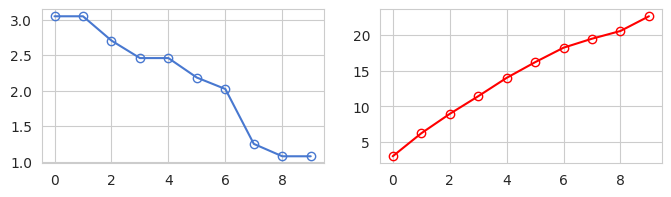

In [14]:
xs = torch.arange(n_iters)

plt.figure(figsize=(8, 2))

plt.subplot(121)
plt.plot(xs, simple_regret, marker='o', markerfacecolor='none')

plt.subplot(122)
plt.plot(xs, cumulative_regret, color='red', marker='o', markerfacecolor='none');

# Making it modular

Evidently, the last three problems followed a very similar design structure. In `bo_torch_2.ipynb`, I'm going to make this more modular by making classes for the following key components:
- Model
- Acquisition function
- BO loop
- Oracle